#Word2Vec with Tensorflow

There are many techniques to get word embeddings, we will discuss one technique which has gained a lot of fame, the one and only, word2vec. Contrary to popular belief, word2vec is not a deep network, it only has 3 layers!
Note : word2vec has a lot of technical details which I will skip over to make the understanding a lot easier.

###How word2vec works:
The idea behind word2vec is that:
1. Take a 3 layer neural network. (1 input layer + 1 hidden layer + 1 output layer)
1. Feed it a word and train it to predict its neighbouring word.
1. Remove the last (output layer) and keep the input and hidden layer.
1. Now, input a word from within the vocabulary. The output given at the hidden layer is the ‘word embedding’ of the input word.

In [1]:
%tensorflow_version 2.x
import tensorflow as tf

In [2]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)

Instructions for updating:
non-resource variables are not supported in the long term
2.8.0


In [3]:
corpus_raw = 'He is the king . The king is royal . She is the royal  queen .'
# convert to lower case
corpus_raw = corpus_raw.lower()

Create a dictionary which translates words to integers and integers to words. This will come in handy later.

In [4]:
words = []
for word in corpus_raw.split():
    if word != '.': # because we don't want to treat . as a word
        words.append(word)
words = set(words) # so that all duplicate words are removed
word2int = {}
int2word = {}
vocab_size = len(words) # gives the total number of unique words
print('vocab size = ', vocab_size)

for i,word in enumerate(words):
    word2int[word] = i
    int2word[i] = word

vocab size =  7


In [5]:
print(word2int['queen'])

6


In [6]:
print(int2word[6])

queen


In [7]:
# raw sentences is a list of sentences.
raw_sentences = corpus_raw.split('.')
sentences = []
for sentence in raw_sentences:
    sentences.append(sentence.split())

In [8]:
print(sentences)

[['he', 'is', 'the', 'king'], ['the', 'king', 'is', 'royal'], ['she', 'is', 'the', 'royal', 'queen'], []]


We need to convert this to an input output pair such that if we input a word, it should it predict that the neighbouring words : the `n` words before and after it, where `n` is the parameter window_size Here’s a handy example from this amazing post on word2vec by Chris McCormick.

Now, we will generate our training data:

In [9]:
train_data = []
WINDOW_SIZE = 2
for sentence in sentences:
    for word_index, word in enumerate(sentence):
        for nb_word in sentence[max(word_index - WINDOW_SIZE, 0) : min(word_index + WINDOW_SIZE, len(sentence)) + 1] : 
            if nb_word != word:
                train_data.append([word, nb_word])

In [10]:
print(train_data)

[['he', 'is'], ['he', 'the'], ['is', 'he'], ['is', 'the'], ['is', 'king'], ['the', 'he'], ['the', 'is'], ['the', 'king'], ['king', 'is'], ['king', 'the'], ['the', 'king'], ['the', 'is'], ['king', 'the'], ['king', 'is'], ['king', 'royal'], ['is', 'the'], ['is', 'king'], ['is', 'royal'], ['royal', 'king'], ['royal', 'is'], ['she', 'is'], ['she', 'the'], ['is', 'she'], ['is', 'the'], ['is', 'royal'], ['the', 'she'], ['the', 'is'], ['the', 'royal'], ['the', 'queen'], ['royal', 'is'], ['royal', 'the'], ['royal', 'queen'], ['queen', 'the'], ['queen', 'royal']]


convert the word to one hot encoding.

In [11]:
# function to convert numbers to one hot vectors
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp
x_train = [] # input word
y_train = [] # output word
for w in train_data:
    x_train.append(to_one_hot(word2int[ w[0] ], vocab_size))
    y_train.append(to_one_hot(word2int[ w[1] ], vocab_size))
# convert them to numpy arrays
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

### Make the tensorflow model
Since tf.placeholder is no loger avaialbe for tf version2, we have to make it compatible with version 1.


In [12]:
# making placeholders for x_train and y_train
# prepare the input layer
x = tf.placeholder(tf.float32, shape=(None, vocab_size))
# prepare the output layer
y_label = tf.placeholder(tf.float32, shape=(None, vocab_size))

Take the training data and convert into the embedded representation.



In [13]:
# prepare hidden layer
EMBEDDING_DIM = 5 # you can choose your own number
W1 = tf.Variable(tf.random_normal([vocab_size, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([EMBEDDING_DIM])) #bias
hidden_representation = tf.add(tf.matmul(x,W1), b1)

Take what we have in the embedded dimension and make a prediction about the neighbour. To make the prediction we use softmax.

In [14]:
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, vocab_size]))
b2 = tf.Variable(tf.random_normal([vocab_size]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_representation, W2), b2))

Train the model

In [ ]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) #make sure you do this!
# define the loss function:
cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), reduction_indices=[1]))
# define the training step:
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy_loss)
n_iters = 100
# train for n_iter iterations
for _ in range(n_iters):
    sess.run(train_step, feed_dict={x: x_train, y_label: y_train})
    print('loss is : ', sess.run(cross_entropy_loss, feed_dict={x: x_train, y_label: y_train}))

All we are interested in is W1 and b1, i.e., the hidden representations.

In [25]:
print(sess.run(W1))
print('----------')
print(sess.run(b1))
print('----------')

[[ 0.45049655  0.23794949  1.0837411   0.7330557  -1.1479896 ]
 [ 0.5940842  -0.37111065  0.00471259  0.10642298  1.1848685 ]
 [-0.63921785  0.7289111   0.28587317 -1.6626531   0.0632097 ]
 [-1.7174872   0.4385366  -0.07284818 -0.7544709   0.53131527]
 [ 0.7432065   0.26722872  0.8357407   0.96763146 -0.33866566]
 [-0.20846169  1.5346657   1.5455717   1.2498138  -0.195111  ]
 [-0.52655786  0.5873418   1.8670385   1.078154   -0.8207269 ]]
----------
[-0.3442267  -0.9412341  -1.7505565   0.38269332 -0.03693294]
----------


When we multiply the one hot vectors with W1 , we basically get access to the row of the of W1 which is in fact the embedded representation of the word represented by the input one hot vector. So W1is essentially acting as a look up table.
In our case we have also included a bias term b1 so you have to add it.

In [26]:
vectors = sess.run(W1 + b1)

# if you work it out, you will see that it has the same effect as running the node hidden representation
print(vectors)

[[ 0.10626987 -0.7032846  -0.6668154   1.115749   -1.1849226 ]
 [ 0.24985752 -1.3123448  -1.7458439   0.4891163   1.1479355 ]
 [-0.9834446  -0.21232301 -1.4646833  -1.2799598   0.02627676]
 [-2.061714   -0.50269747 -1.8234047  -0.37177756  0.49438232]
 [ 0.3989798  -0.6740054  -0.9148158   1.3503247  -0.3755986 ]
 [-0.55268836  0.5934316  -0.20498478  1.6325071  -0.23204395]
 [-0.8707845  -0.35389233  0.11648202  1.4608473  -0.8576598 ]]


In [27]:
def euclidean_dist(vec1, vec2):
    return np.sqrt(np.sum((vec1-vec2)**2))
def find_closest(word_index, vectors):
    min_dist = 10000 # to act like positive infinity
    min_index = -1
    query_vector = vectors[word_index]
    for index, vector in enumerate(vectors):
        if euclidean_dist(vector, query_vector) < min_dist and not np.array_equal(vector, query_vector):
            min_dist = euclidean_dist(vector, query_vector)
            min_index = index
    return min_index

In [28]:
print(int2word[find_closest(word2int['king'], vectors)])
print(int2word[find_closest(word2int['queen'], vectors)])
print(int2word[find_closest(word2int['royal'], vectors)])

royal
is
king


In [29]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors = model.fit_transform(vectors)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [30]:
from sklearn import preprocessing
normalizer = preprocessing.Normalizer()
vectors =  normalizer.fit_transform(vectors, 'l2')

royal 0.89717036
he 0.25030422
the 0.96019673
she 0.5068005
king -0.9047838
is 0.9838481
queen -0.4028841


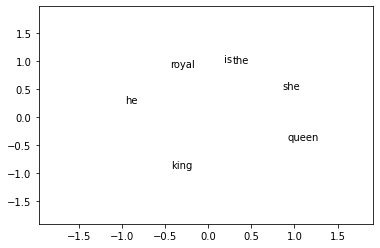

In [31]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for word in words:
    print(word, vectors[word2int[word]][1])
    ax.annotate(word, (vectors[word2int[word]][0],vectors[word2int[word]][1] ))
    
ax.set_xlim(min([vectors[word2int[w]][0] for w in words])-1, max([vectors[word2int[w]][0] for w in words])+1)
ax.set_ylim(min([vectors[word2int[w]][1] for w in words])-1, max([vectors[word2int[w]][1] for w in words])+1)
plt.show()